<a href="https://colab.research.google.com/github/SHAIK-MOHAMMAD-IRFAN27/VR-mini-project/blob/main/VR_TASK1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests

# GitHub repository details
repo_owner = "chandrikadeb7"
repo_name = "Face-Mask-Detection"
folder_path = "dataset/with_mask"

# GitHub API URL to get file details
api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}"

# Headers to avoid rate limiting (GitHub API requires a user-agent)
headers = {"User-Agent": "Mozilla/5.0"}

# ✅ Set save directory in Google Drive
save_dir = "/content/drive/MyDrive/FaceMaskDataset/with_mask"
os.makedirs(save_dir, exist_ok=True)

# Get the list of files in the folder
response = requests.get(api_url, headers=headers)
if response.status_code == 200:
    files = response.json()

    for file in files:
        if file["name"].endswith((".jpg", ".jpeg", ".png")):  # Filter images
            img_url = file["download_url"]
            img_name = file["name"]
            img_path = os.path.join(save_dir, img_name)

            # Download and save the image
            img_data = requests.get(img_url).content
            with open(img_path, "wb") as handler:
                handler.write(img_data)

            print(f"Downloaded: {img_name}")

    print("✅ All images saved in Google Drive!")
else:
    print("❌ Failed to fetch file list. Check the repository URL or API rate limits.")

Downloaded: 0129.png
Downloaded: 0323.jpg
Downloaded: 0417.jpg
Downloaded: 0502.png
Downloaded: 0803.jpg
Downloaded: 0932.jpg
Downloaded: 0999.png
Downloaded: 0_0_0 copy 10.jpg
Downloaded: 0_0_0 copy 11.jpg
Downloaded: 0_0_0 copy 12.jpg
Downloaded: 0_0_0 copy 13.jpg
Downloaded: 0_0_0 copy 14.jpg
Downloaded: 0_0_0 copy 15.jpg
Downloaded: 0_0_0 copy 16.jpg
Downloaded: 0_0_0 copy 17.jpg
Downloaded: 0_0_0 copy 18.jpg
Downloaded: 0_0_0 copy 19.jpg
Downloaded: 0_0_0 copy 2 2.jpg
Downloaded: 0_0_0 copy 2.jpg
Downloaded: 0_0_0 copy 2.png
Downloaded: 0_0_0 copy 20.jpg
Downloaded: 0_0_0 copy 21.jpg
Downloaded: 0_0_0 copy 22.jpg
Downloaded: 0_0_0 copy 23.jpg
Downloaded: 0_0_0 copy 24.jpg
Downloaded: 0_0_0 copy 25.jpg
Downloaded: 0_0_0 copy 26.jpg
Downloaded: 0_0_0 copy 27.jpg
Downloaded: 0_0_0 copy 28.jpg
Downloaded: 0_0_0 copy 29.jpg
Downloaded: 0_0_0 copy 3 2.jpg
Downloaded: 0_0_0 copy 3.jpg
Downloaded: 0_0_0 copy 3.png
Downloaded: 0_0_0 copy 30.jpg
Downloaded: 0_0_0 copy 31.jpg
Downloaded: 0_0

In [ ]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       198
           1       0.94      0.95      0.94       201

    accuracy                           0.94       399
   macro avg       0.94      0.94      0.94       399
weighted avg       0.94      0.94      0.94       399

3-Layer MLP Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       198
           1       0.95      0.93      0.94       201

    accuracy                           0.94       399
   macro avg       0.94      0.94      0.94       399
weighted avg       0.94      0.94      0.94       399



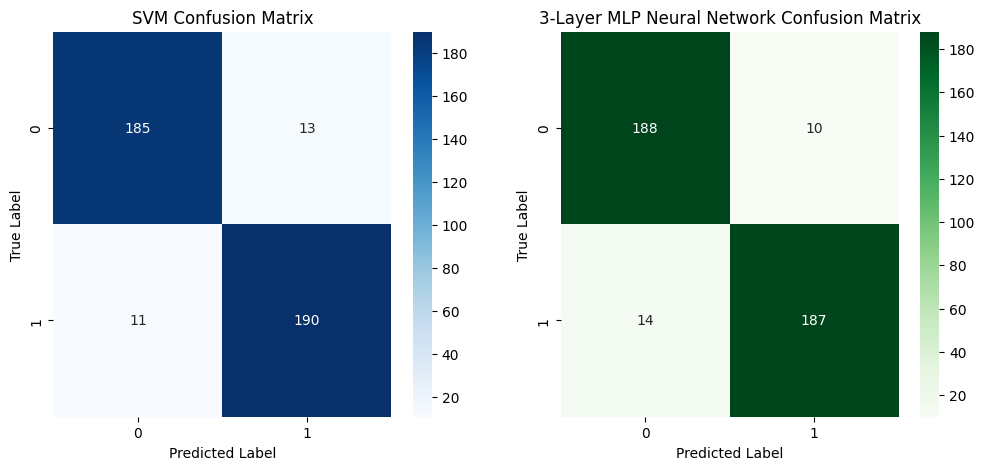

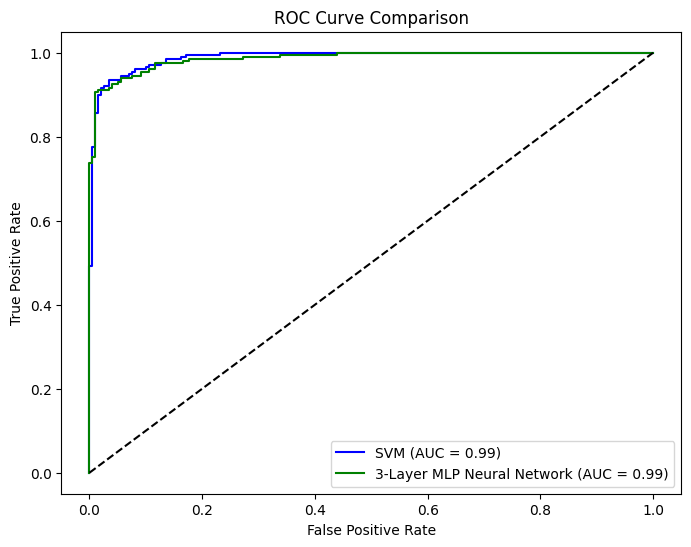

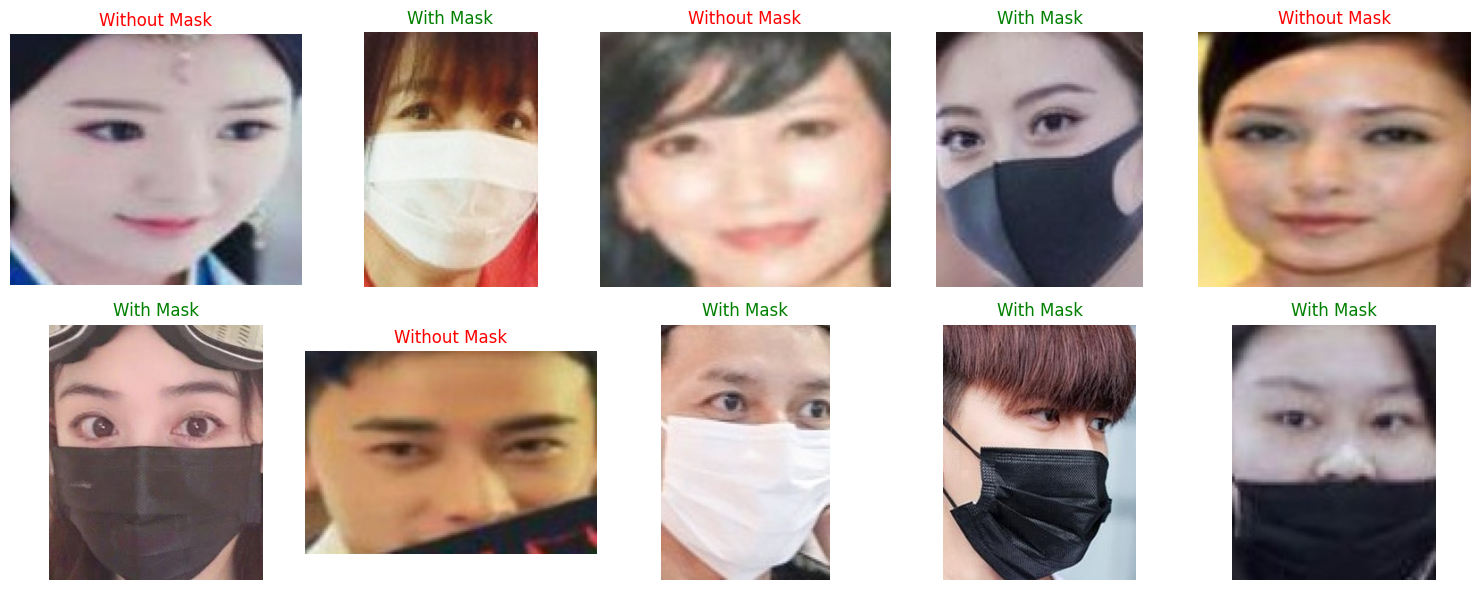

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Directories
without_mask_dir = "/content/drive/My Drive/FaceMaskDataset/without_mask"
with_mask_dir = "/content/drive/My Drive/FaceMaskDataset/with_mask"

# Image size
IMAGE_SIZE = (128, 128)

# Feature extraction function
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, IMAGE_SIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Color Histogram (RGB)
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # 2. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)

    # 3. GLCM (Texture Features)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # 4. HOG Features
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True)

    # Concatenate features
    feature_vector = np.hstack([hist, lbp_hist, [contrast, correlation], hog_features])

    return feature_vector

# Load dataset
features, labels, image_paths = [], [], []

for category, label in [(without_mask_dir, 0), (with_mask_dir, 1)]:
    for file in os.listdir(category):
        if file.endswith(".jpg") or file.endswith(".png"):
            img_path = os.path.join(category, file)
            try:
                feature_vector = extract_features(img_path)
                features.append(feature_vector)
                labels.append(label)
                image_paths.append(img_path)  # Save image path for visualization
            except Exception as e:
                print(f"Skipping {file}: {e}")

# Convert to NumPy array
features = np.array(features, dtype=np.float32)
labels = np.array(labels)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(features, labels, image_paths, test_size=0.2, random_state=42)

# Train SVM Classifier
svm_model = SVC(kernel="linear", probability=True)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_prob = svm_model.predict_proba(X_test)[:, 1]
svm_accuracy = accuracy_score(y_test, svm_pred)

# Train Neural Network (MLP) with 3 layers
mlp_model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # 3 hidden layers with decreasing size
    max_iter=1000,
    activation='relu',  # ReLU activation function for non-linearity
    solver='adam',  # Adam optimizer (good for most cases)
    random_state=42
)

mlp_model.fit(X_train, y_train)

mlp_pred = mlp_model.predict(X_test)
mlp_prob = mlp_model.predict_proba(X_test)[:, 1]

print("SVM Classification Report:\n", classification_report(y_test, svm_pred))
print("3-Layer MLP Classification Report:\n", classification_report(y_test, mlp_pred))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("SVM Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(confusion_matrix(y_test, mlp_pred), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("3-Layer MLP Neural Network Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()


fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_prob)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_prob)

auc_svm = auc(fpr_svm, tpr_svm)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})", color="blue")
plt.plot(fpr_mlp, tpr_mlp, label=f"3-Layer MLP Neural Network (AUC = {auc_mlp:.2f})", color="green")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    img = cv2.imread(img_test[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    label_text = "With Mask" if svm_pred[i] == 1 else "Without Mask"
    color = "green" if svm_pred[i] == 1 else "red"

    axes[i].imshow(img)
    axes[i].set_title(label_text, color=color)
    axes[i].axis("off")

plt.tight_layout()
plt.show()
